<a href="https://colab.research.google.com/github/raulbenitez/NEUROIMAGING_AI/blob/main/NI_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install nilearn

     |████████████████████████████████| 9.6 MB 8.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.7 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Load data

In [38]:
import nibabel as nib
from nilearn.datasets import MNI152_FILE_PATH
from matplotlib import pyplot as plt
import numpy as np

# Now, we read the image with nibabel (nib), and we convert it to a numpy matrix
print(MNI152_FILE_PATH)
img = nib.load(MNI152_FILE_PATH)
data = img.get_fdata()
data.shape

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/data/mni_icbm152_t1_tal_nlin_sym_09a_converted.nii.gz


(197, 233, 189)

# Volume segmentation (k-means)

In [39]:
import skimage as sk # load skimage libraries
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import gridspec

v_I = np.reshape(data,(data.shape[0]*data.shape[1]*data.shape[2],1)) # reshape image as NPIX x NCHANNELS array
kmeans = KMeans(n_clusters=5).fit(v_I) # Fit a k-means algorithm
v_kmeans = kmeans.fit_predict(v_I) # Predict k-means cluster labels for each pixel
I_segment = np.reshape(v_kmeans,(data.shape[0],data.shape[1],data.shape[2])) # reshape back to original image size

In [40]:
np.unique(I_segment)

array([0, 1, 2, 3, 4], dtype=int32)

# Visualization

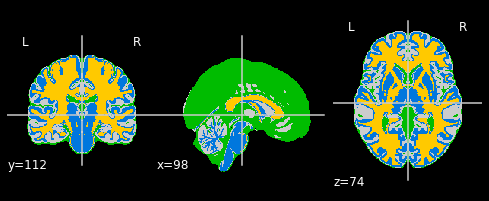

In [41]:
from nilearn.plotting import plot_epi, show
import nibabel as nib
import numpy as np

new_image = nib.Nifti1Image(I_segment, np.eye(4))
new_image.set_data_dtype(np.int64)
plot_epi(new_image)

# Feature extraction (regional properties)

In [42]:
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd  

from skimage import util, measure

def quartiles(regionmask, intensity):
    return np.percentile(intensity[regionmask], q=(25, 50, 75))


props = regionprops_table(I_segment,intensity_image=data,properties=('centroid','area','label',),extra_properties=(quartiles,))   
df_props = pd.DataFrame(props)  
df_props.head()                                                  

,centroid-0,centroid-1,centroid-2,area,label,quartiles-0,quartiles-1,quartiles-2
0,98.0,108.347991,79.477686,626981,1,174.0,181.0,189.0
1,98.0,108.696664,78.877046,194072,2,93.0,109.0,120.0
2,98.0,117.122332,90.630394,581992,3,208.0,217.0,222.0
3,98.0,111.928111,74.318350,479698,4,146.0,156.0,162.0


Shannon's Entropy

In [46]:
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.measure import shannon_entropy
import skimage as sk 

def entropy_image(imgG):

    img = img_as_ubyte(imgG) # convert to uint8

# Local entropy in a certain pixel neiborhood:
    shannon_img = shannon_entropy(img)
    print('Shannon ={}'.format(shannon_img))
# Flatten the image (convert from matrix to vector):
    v = img.flatten()
# For each grayscale leve, get the pixel probability of occurrence:
    probg,edges = np.histogram(v,bins=np.arange(256), density=True)
    eps = 1e-16
    probg = probg + eps
# Compute Shannon's entropy:
    H_noise = -np.sum(probg * np.log2(probg), axis=0)
# Compare: 
    print('Entropy = {}'.format(H_noise))
    return shannon_img

In [47]:
props1 = regionprops_table(I_segment,intensity_image=data,properties=('centroid','area','label',),extra_properties=(quartiles,entropy_image,))   
df_props1 = pd.DataFrame(props1)  
df_props1.head() 

Shannon =0.6324022445466285
Entropy = 0.632402244547973
Shannon =0.22853814395352803
Entropy = 0.2285381439548729
Shannon =0.876716288999464
Entropy = 0.8767162890008087
Shannon =0.6324022445466285
Entropy = 0.632402244547973
Shannon =0.27657661416307544
Entropy = 0.27657661416442025
Shannon =0.6465458934199002
Entropy = 0.6465458934212447
Shannon =0.5322709840969412
Entropy = 0.5322709840982857


,centroid-0,centroid-1,centroid-2,area,label,quartiles-0,quartiles-1,quartiles-2,entropy_image
0,98.0,108.347991,79.477686,626981,1,174.0,181.0,189.0,0.632402
1,98.0,108.696664,78.877046,194072,2,93.0,109.0,120.0,0.276577
2,98.0,117.122332,90.630394,581992,3,208.0,217.0,222.0,0.646546
3,98.0,111.928111,74.318350,479698,4,146.0,156.0,162.0,0.532271


Texture features ina slice

array([313.30564529,   0.78041985,   0.7495941 ,   0.97029199])

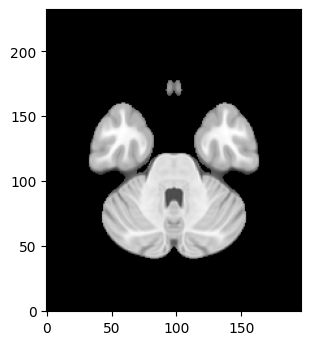

In [81]:
from skimage.feature.texture import greycomatrix,greycoprops

# Plot slice 40 (axial view). We transpose the image and set origin to lower, to see the axial representation
n_slice = 40 
I = data[:,:,n_slice].T
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
imgplot = plt.imshow(I,cmap='gray', origin='lower')

I1 = np.uint8(I) # convert to uint8

g = greycomatrix(I1,[2], [np.pi/2],normed=True, symmetric=True)
contrast = greycoprops(g,'contrast')
homogeneity = greycoprops(g, 'homogeneity')
energy = greycoprops(g, 'energy')
correlation = greycoprops(g, 'correlation')

X = np.array([contrast,homogeneity,energy,correlation]).squeeze()
X

In [79]:
X = np.array([contrast,homogeneity,energy,correlation]).squeeze()
X.shape

(4,)